### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 21 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 21 декабря, -4 балла после 08:30 28 декабря, -6 баллов после 08:30 04 янва, -8 баллов после 08:30 11 января.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

для k-ого алгоритма в бустинге таргет:

mse:
$$y_{ki} = 2(y_i - F_{k-1}(x_i))$$
exp:
$$y_{ki} = y_iexp(-F_{k-1}(x_i)y_i)$$
log:
$$ y_{ki} = \frac{y_iexp(-F_{k-1}(x_i)y_i)}{1+exp(-F_{k-1}(x_i)y_i)}$$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from tqdm import tqdm

In [2]:
class MyGradientBoostingClassifier:
    
    def new_y(self, y, F):
        if self.loss == 'mse':
            return 2 * (y - F)
        if self.loss == 'exp':
            return y * np.exp(-F * y)
        if self.loss == 'log':
            return y * np.exp(-F * y) / (1 + np.exp(-F * y))

    def __init__(self, loss='mse', learning_rate=0.2, n_estimators=6, colsample=0.5, subsample=0.5):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        """
        # Ваш код здесь
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None, *args, **kwargs):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.models = []
        self.cols = []
        
        if init_model is None:
            F = np.zeros(len(y))
        else:
            model = init_model()
            model.fit(X, y)
            self.models.append(model)
            self.cols.append(list(range(X.shape[1])))
            F = np.asarray(model.predict(X))
        
        for i in range(self.n_estimators):
            #colsample
            cols = list(range(X.shape[1]))
            random.shuffle(cols)
            cols = cols[:round(X.shape[1] * self.colsample)]
            X_i_all = X[:, cols] 
            
            #subsample
            subs = list(range(X.shape[0]))
            random.shuffle(subs)
            subs = subs[:round(X.shape[0] * self.subsample)]
            X_i = X_i_all[subs, :] 
            y_i = y[subs]
            F_i = F[subs] 
            
            #fit
            model = base_model(*args, **kwargs)
            model.fit(X_i, self.new_y(y_i, F_i))
            self.models.append(model)
            self.cols.append(cols)
            F = F + self.learning_rate * np.asarray(model.predict(X_i_all))
            
        
    def predict(self, X):
        # Ваш код здесь
        F = np.zeros(len(X))
        for i in range(len(self.models)):
            F = F + self.learning_rate * np.asarray(self.models[i].predict(X[:, self.cols[i]]))
        return np.round(F)

In [3]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.8888888888888888


In [6]:
# Как-то сильно скор отличается в зависимости от train_test_split, захотелось посмотреть в среднем
accuracy_sklearn = []
accuracy_my = []
wine = load_wine()
for i in tqdm(range(100)):
    X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)
    my_clf.fit(X_train, y_train)
    clf.fit(X_train, y_train)
    accuracy_sklearn.append(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
    accuracy_my.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
np.mean(accuracy_sklearn), np.mean(accuracy_my)
# Как раз меньше пяти процентов разница

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.90it/s]


(0.9483333333333333, 0.9144444444444444)

## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [7]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [8]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


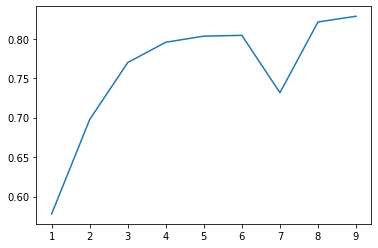

In [9]:
acc = []
for n in range(1, 10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    my_clf = MyGradientBoostingClassifier(n_estimators=n)
    my_clf.fit(X_train, y_train)
    acc.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
plt.plot(list(range(1, 10)), acc)

In [10]:
best_acc = 0
best_loss = ""
best_lr = 0
best_c = 0
best_s = 0
best_n = 0
for alpha in tqdm(np.linspace(0.01, 0.8, 6)):
    for n in range(2, 6):
        for c in np.linspace(0.12, 1, 4):
            for s in np.linspace(0.01, 1, 4):
                for l in ['mse', 'exp', 'log']:
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
                    my_clf = MyGradientBoostingClassifier(loss = l, learning_rate=alpha, 
                                                          n_estimators=n, colsample=c, subsample=s)
                    my_clf.fit(X_train, y_train)
                    acc = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
                    if acc > best_acc:
                        best_acc = acc
                        best_loss = l
                        best_lr = alpha
                        best_c = c
                        best_s = s
                        best_n = n
print("best_accuracy =", best_acc, "with loss '", best_loss, "', colsample =", 
      best_c, ", subsample =", best_s, ", n_estimators =", best_n, "and learning rate =", best_lr)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:22<00:00, 33.83s/it]

best_accuracy = 0.8803294573643411 with loss ' log ', colsample = 1.0 , subsample = 0.67 , n_estimators = 5 and learning rate = 0.484


## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [11]:
N = 20 # колво бустингов / колво деревьев в каждом лесе
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
my_clf = MyGradientBoostingClassifier(loss = best_loss, learning_rate=best_lr, 
                                        n_estimators=best_n, colsample=best_c, subsample=best_s)
my_clf.fit(X_train, y_train, DecisionTreeRegressor)
print("бустинг просто на деревьях:", accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))



X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.1, stratify=y)
my_clf = MyGradientBoostingClassifier(loss = best_loss, learning_rate=best_lr, 
                                        n_estimators=n, colsample=c, subsample=s)
my_clf.fit(X_train, y_train, RandomForestRegressor, n_estimators=N)
print("бустинг на лесах из N деревьев с теми же параметрами бустинга:", accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

бустинг просто на деревьях: 0.8541666666666666
бустинг на лесах из N деревьев с теми же параметрами бустинга: 0.8842054263565892


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
ans = np.zeros(len(y_test))
for i in range(N):
    indices = np.random.randint(0, len(y_train), (1, len(y_train)))[0]
    X_b = X_train[indices, :]
    y_b = y_train[indices]
    my_clf = MyGradientBoostingClassifier(loss = best_loss, learning_rate=best_lr, 
                                        n_estimators=best_n, colsample=best_c, subsample=best_s)
    my_clf.fit(X_b, y_b, DecisionTreeRegressor)
    ans += my_clf.predict(X_test)
ans = ans / N
ans = np.round(ans)
print("усреднение по N бустингам с теми же параметрами:", accuracy_score(y_pred=ans, y_true=y_test))

усреднение по N бустингам с теми же параметрами: 0.875


In [13]:
# Качество улучшилось в обоих способах. Видимо, variance был довольно велик 
# в бустинге из-за переобучения, и усреднение на каждом шаге 
# по N деревьям / усреднение N бустингов этот variance уменьшило

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
my_clf = MyGradientBoostingClassifier(loss = best_loss, learning_rate=best_lr, 
                                    n_estimators=best_n, colsample=best_c, subsample=best_s)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, RandomForestClassifier)
print("init is Forest:", accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
my_clf = MyGradientBoostingClassifier(loss = best_loss, learning_rate=best_lr, 
                                    n_estimators=best_n, colsample=best_c, subsample=best_s)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, SVC)
print("init is SVC:", accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
my_clf = MyGradientBoostingClassifier(loss = best_loss, learning_rate=best_lr, 
                                    n_estimators=best_n, colsample=best_c, subsample=best_s)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, LogisticRegression)
print("init is LogisticRegression:", accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

init is Forest: 0.8880813953488372
init is SVC: 0.8599806201550387


C:\Users\Sasha\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


init is LogisticRegression: 0.8544089147286822


In [15]:
# RandomForest с большим количеством деревьев в качестве init_model даёт прирост в точности,
# так как лес сам по себе хорошо разделяет классы, а потом деревья доисправляют ошибки.

# SVC и LogisticRegression дают незначительное изменение в точности. Я думаю, это связано с тем,
# что данные не очень хорошо линейно разделимы, и при инициализации получается достаточная ошибка, 
# которую деревья не успевают полностью исправить за колво итераций n_estimators и шагом learning_rate, 
# которые подбирались для константной инициализации

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

